In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# to ignore the warning of pandas chained assignment
pd.options.mode.chained_assignment = None

# dataset from https://www.kaggle.com/robikscube/hourly-energy-consumption

# using pjm_hourly_est.csv file because it has the records of the whole PJM regions together
df = pd.read_csv('data/pjm_hourly_est.csv')

# sort by date
df.sort_values(by=['Datetime'], inplace=True)

# set Datetime as index
df.set_index('Datetime', inplace=True)

# convert index to datetime
df.index = pd.to_datetime(df.index)


df.head()

,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
Datetime,,,,,,,,,,,,
1998-04-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22259.0
1998-04-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21244.0
1998-04-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20651.0
1998-04-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20421.0
1998-04-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20713.0


In [2]:
# describing the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AEP,121273.0,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.00,25695.0
COMED,66497.0,11420.152112,2304.139517,7237.0,9780.0,11152.0,12510.00,23753.0
DAYTON,121275.0,2037.851140,393.403153,982.0,1749.0,2009.0,2279.00,3746.0
DEOK,57739.0,3105.096486,599.859026,907.0,2687.0,3013.0,3449.00,5445.0
DOM,116189.0,10949.203625,2413.946569,1253.0,9322.0,10501.0,12378.00,21651.0
DUQ,119068.0,1658.820296,301.740640,1014.0,1444.0,1630.0,1819.00,3054.0
EKPC,45334.0,1464.218423,378.868404,514.0,1185.0,1386.0,1699.00,3490.0
FE,62874.0,7792.159064,1331.268006,0.0,6807.0,7700.0,8556.00,14032.0
NI,58450.0,11701.682943,2371.498701,7003.0,9954.0,11521.0,12896.75,23631.0
PJME,145366.0,32080.222831,6464.012166,14544.0,27573.0,31421.0,35650.00,62009.0


In [3]:
# check for duplicates
df.duplicated().sum()

16181

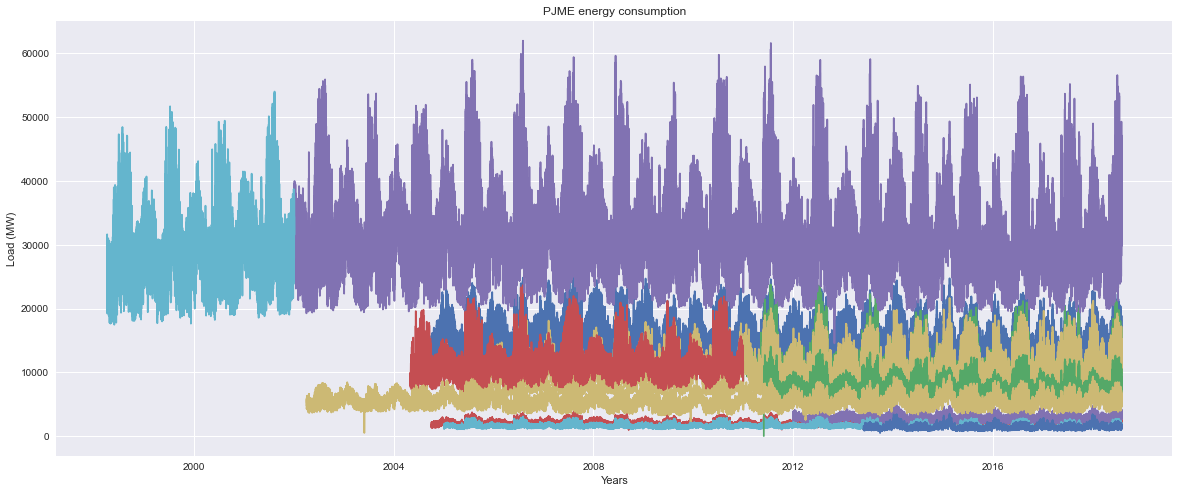

In [4]:

# Distribution of Load for all regions
plt.style.use('seaborn')
plt.figure(figsize=(20, 8))
plt.plot(df)
plt.xlabel('Years')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.show()

# we see that each region has a different energy consumption pattern
# so its better to make predictions for each region separately
# we choose the region with the most data "least missing values"

<AxesSubplot:>

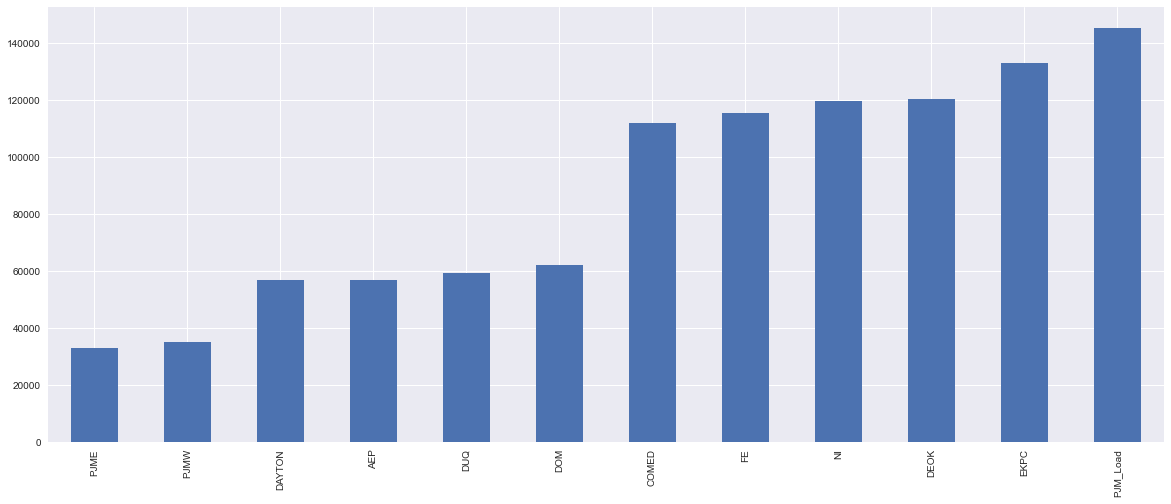

In [5]:
# check for missing values
missing_values_df = df.isnull().sum()

# plot the missing values
missing_values_df.sort_values(ascending=True).plot(kind='bar', figsize=(20, 8))

# the one with the least missing values is PJME

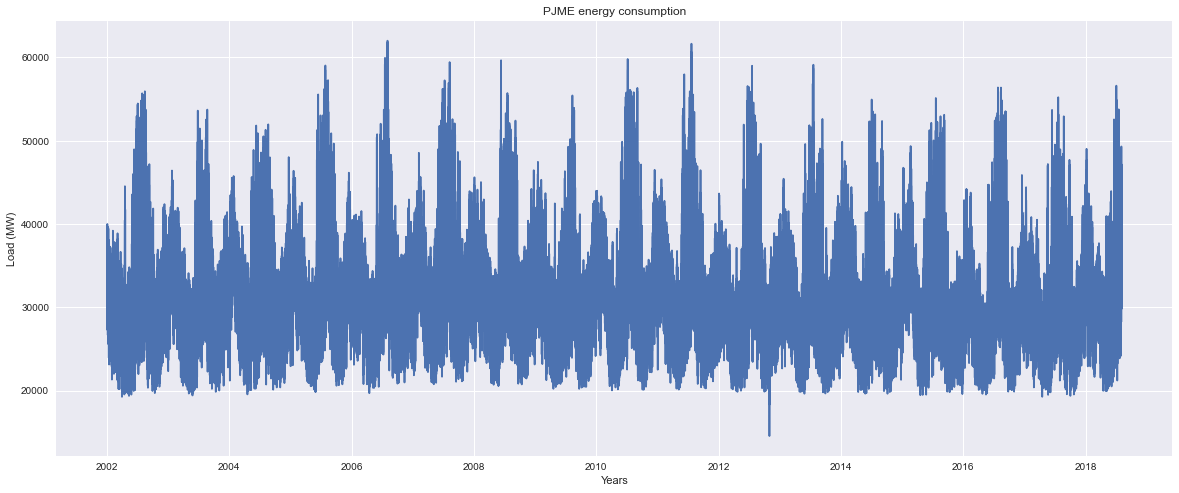

In [6]:
# removing all columns except PJME
df = df[['PJME']]

# removing the missing values
df.dropna(inplace=True)

# visualizing the data
plt.figure(figsize=(20, 8))
plt.plot(df)
plt.xlabel('Years')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.show()

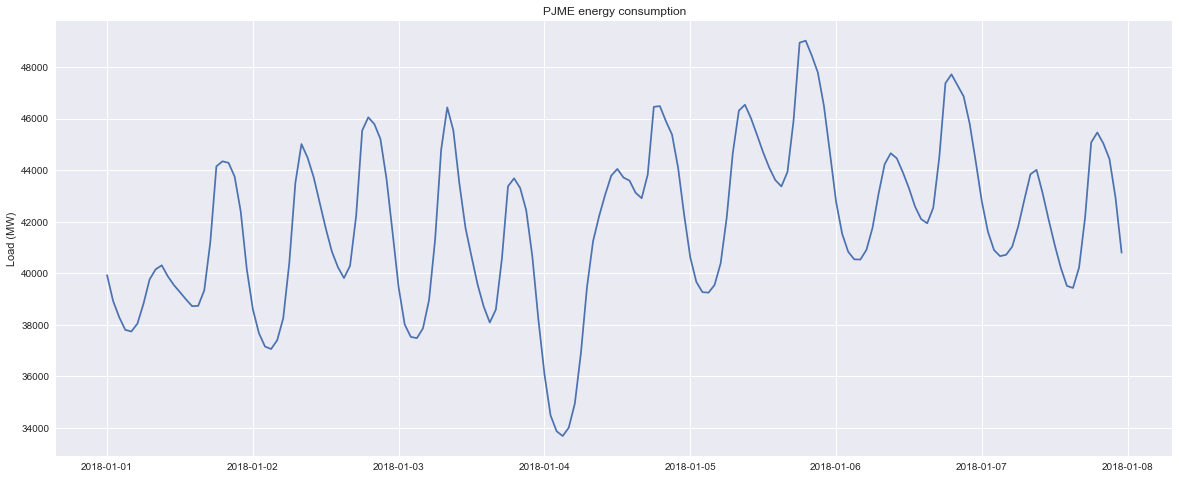

In [7]:
# visualizing a single week
plt.figure(figsize=(20, 8))
plt.plot(df['2018-01-01':'2018-01-07'])
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.show()

In [8]:
# a function that will split the index to be used for hourly, daily, weekly, monthly, yearly and seasonal analysis

def split_df_features_for_plotting(df):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.day_of_week
    df['day_of_week'] = df['day_of_week'].replace({0: 'monday', 1: 'tuesday', 2: 'wednesday', 3: 'thursday', 4: 'friday', 5: 'saturday', 6: 'sunday'})
    df['month'] = df.index.month
    df['month'] = df['month'].replace({1: 'january', 2: 'february', 3: 'march', 4: 'april', 5: 'may', 6: 'june', 7: 'july', 8: 'august', 9: 'september', 10: 'october', 11: 'november', 12: 'december'})
    df['year'] = df.index.year
    df['season'] = df.index.month % 12 // 3 + 1
    df['season'] = df['season'].replace({1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'})
    return df

df2 = df.copy()
df2 = split_df_features_for_plotting(df2)
df2.head()

,PJME,hour,day_of_week,month,year,season
Datetime,,,,,,
2002-01-01 01:00:00,30393.0,1,tuesday,january,2002,winter
2002-01-01 02:00:00,29265.0,2,tuesday,january,2002,winter
2002-01-01 03:00:00,28357.0,3,tuesday,january,2002,winter
2002-01-01 04:00:00,27899.0,4,tuesday,january,2002,winter
2002-01-01 05:00:00,28057.0,5,tuesday,january,2002,winter


Text(0.5, 1.0, 'PJME energy consumption by hour')

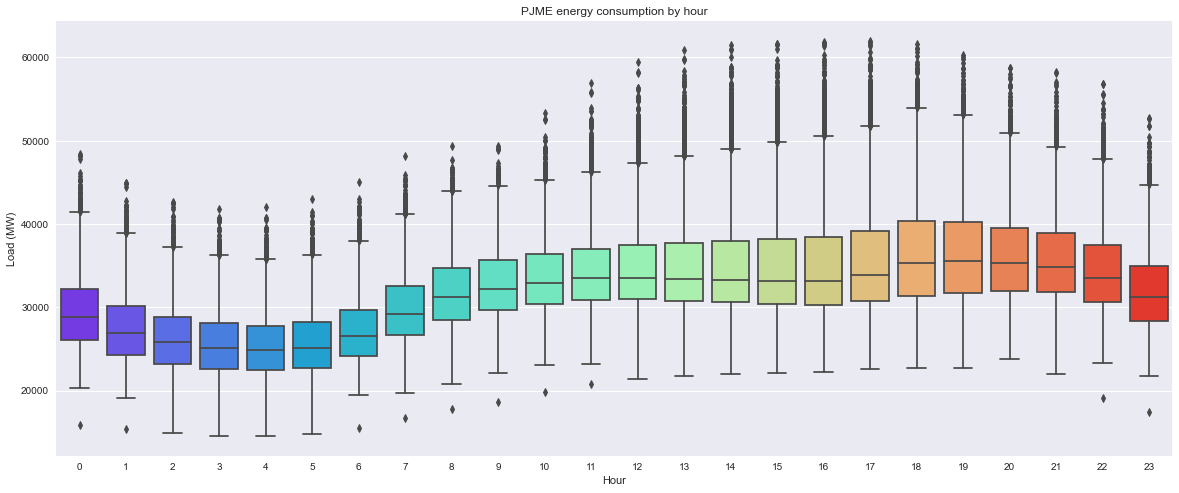

In [9]:
# we use seaborn to visualize the data
# plotting the hourly energy use

plt.figure(figsize=(20, 8))
sns.boxplot(x='hour', y='PJME', data=df2, palette='rainbow')
plt.xlabel('Hour')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption by hour')

Text(0.5, 1.0, 'PJME energy consumption by month')

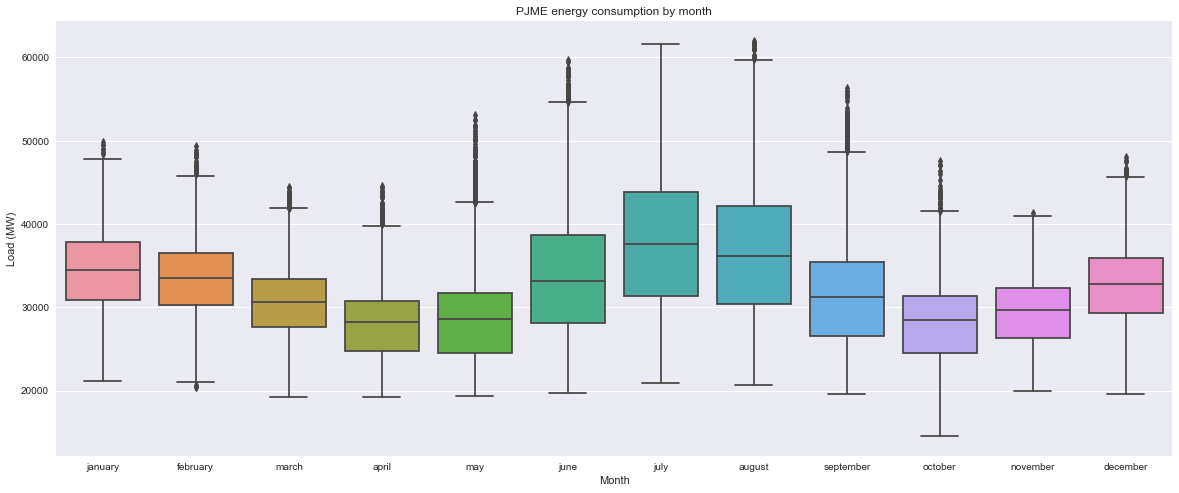

In [10]:
# plotting the monthly energy use

plt.figure(figsize=(20, 8))
sns.boxplot(x='month', y='PJME', data=df2)
plt.xlabel('Month')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption by month')


Text(0.5, 1.0, 'PJME energy consumption by day of week')

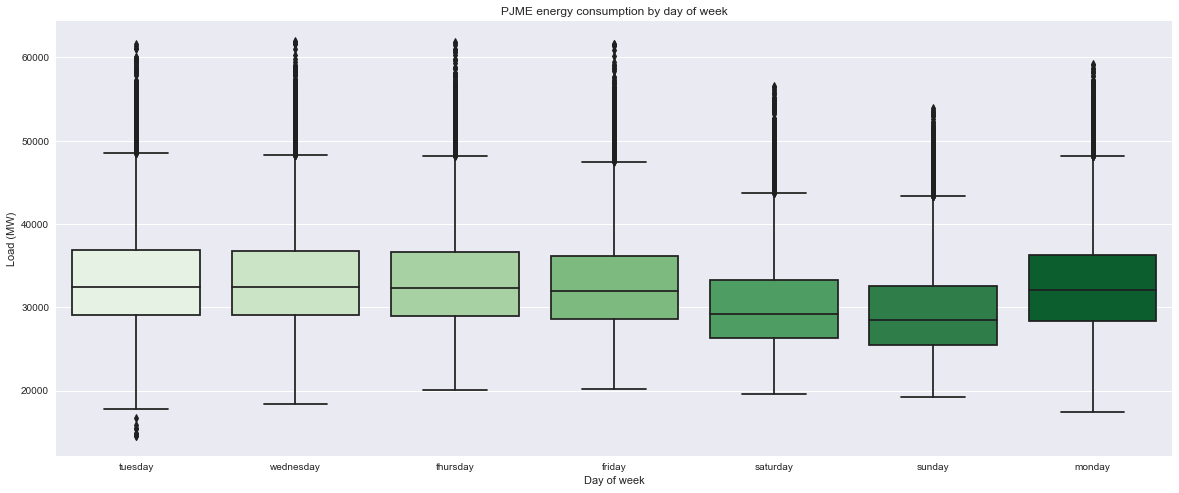

In [11]:
# plotting the daily energy use
plt.figure(figsize=(20, 8))
sns.boxplot(x='day_of_week', y='PJME', data=df2, palette='Greens')
plt.xlabel('Day of week')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption by day of week')

Text(0.5, 1.0, 'PJME energy consumption by season')

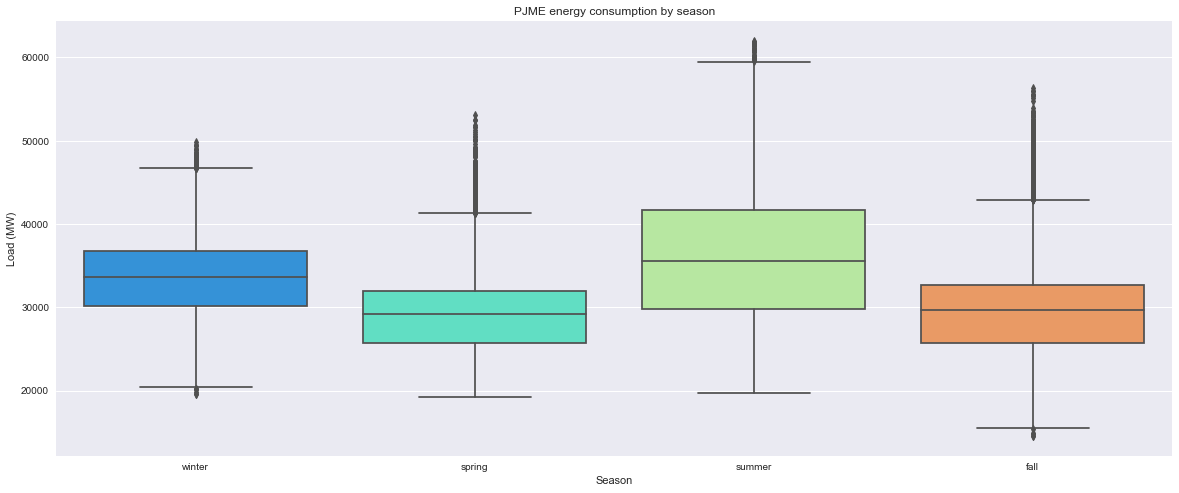

In [12]:
# plotting the seasonal energy use
plt.figure(figsize=(20, 8))
sns.boxplot(x='season', y='PJME', data=df2, palette='rainbow')
plt.xlabel('Season')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption by season')


Text(0.5, 1.0, 'PJME energy consumption by day of week and hour')

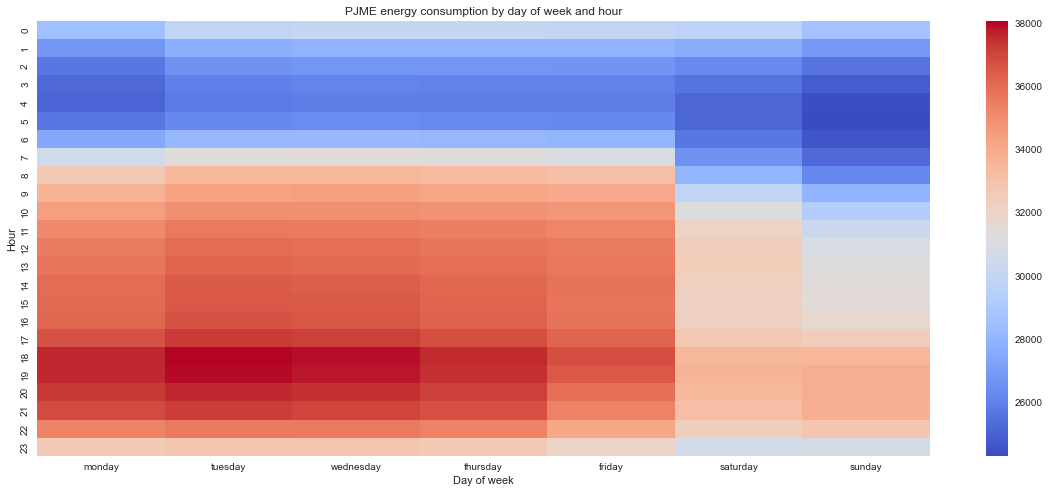

In [13]:
# heatmap of daily energy use
plt.figure(figsize=(20, 8))

# sorting the day of week before plotting
df2['day_of_week'] = pd.Categorical(df2['day_of_week'], categories=['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'], ordered=True)

sns.heatmap(df2.groupby(['hour', 'day_of_week'])['PJME'].mean().unstack(), cmap='coolwarm')
plt.xlabel('Day of week')
plt.ylabel('Hour')
plt.title('PJME energy consumption by day of week and hour')


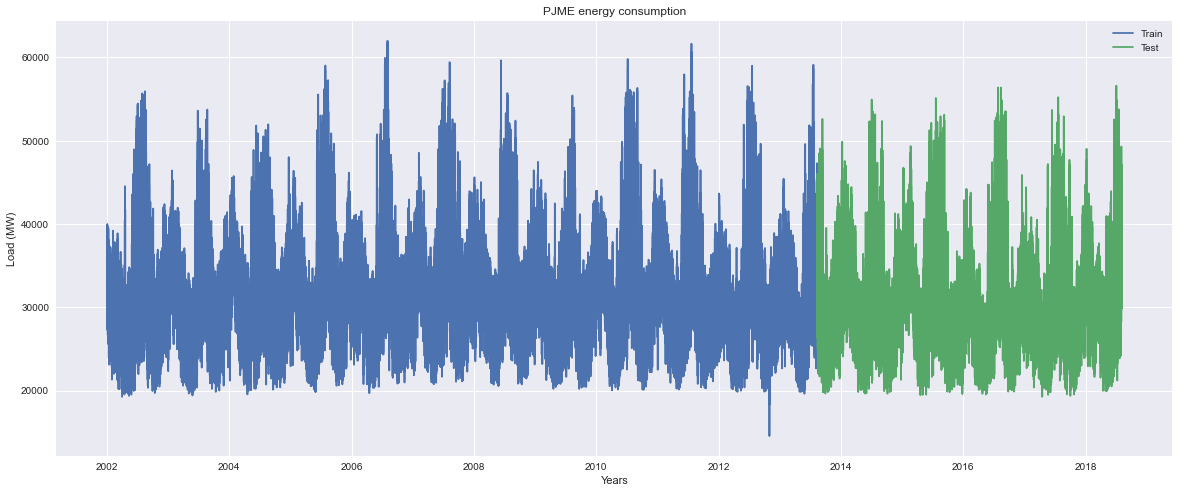

In [14]:


# splitting the data into test 70% train and 30% test
test_size = int(len(df) * 0.3)
test_index = len(df) - test_size
train = df[:test_index]
test = df[test_index:]

# plotting the train and test data
plt.figure(figsize=(20, 8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Years')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.legend()
plt.show()

In [15]:
from sklearn.preprocessing import MinMaxScaler

# a function to normalize the data
def normalize_data(df):
    scaler = MinMaxScaler()
    temp = df.values
    temp = temp.astype('float32')
    df = scaler.fit_transform(temp)
    return df

train = normalize_data(train)
test = normalize_data(test)

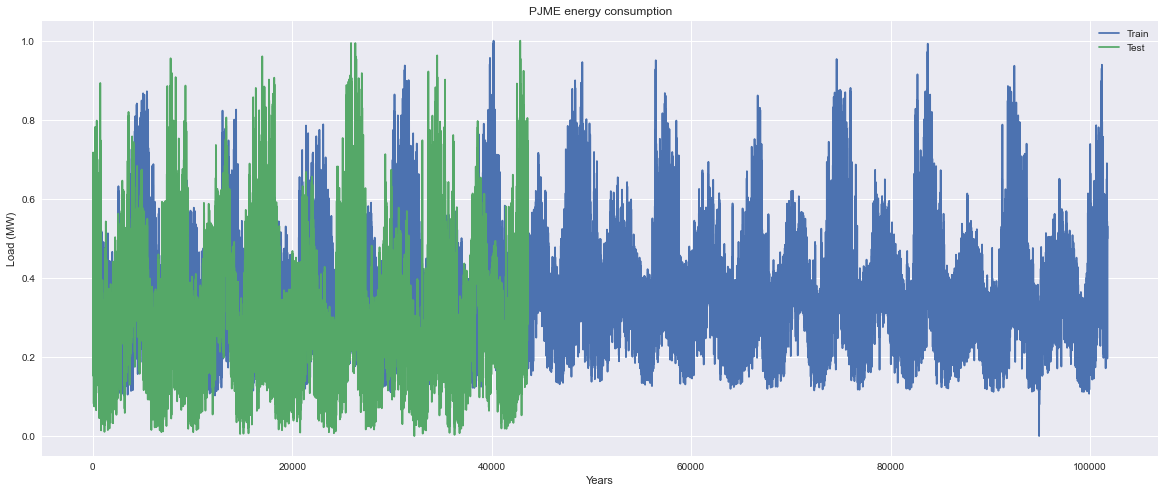

In [16]:
# plotting the normalized data
plt.figure(figsize=(20, 8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Years')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.legend()
plt.show()

In [17]:
# function to convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [18]:
# reshape into X=t and Y=t+1
look_back = 5
x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

In [19]:
# reshaping the input to be used by the LSTMs model
# The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].
# Currently, the data is in the form: [samples, features]. 
# Using numpy.reshape() to transform the input data into the right structure [samples, time steps, features].

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((101751, 1, 5), (43603, 1, 5), (101751,), (43603,))

In [20]:
# using LSTMs to predict the energy consumption

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop


def create_model():
    # creating the model
    model = Sequential()

    # adding the LSTM layer
    model.add(LSTM(24, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))

    # another LSTM layer
    model.add(LSTM(24, return_sequences=False))

    # dense layer
    model.add(Dense(1))

    # compiling the model
    model.compile(loss='mse', optimizer='sgd')
    return model



model = create_model()
# fitting the model
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))



Epoch 1/5
3180/3180 [==============================] - 37s 8ms/step - loss: 0.0190 - val_loss: 0.0297
Epoch 2/5
3180/3180 [==============================] - 33s 11ms/step - loss: 0.0171 - val_loss: 0.0278
Epoch 3/5
3180/3180 [==============================] - 23s 7ms/step - loss: 0.0159 - val_loss: 0.0250
Epoch 4/5
3180/3180 [==============================] - 18s 6ms/step - loss: 0.0143 - val_loss: 0.0219
Epoch 5/5
3180/3180 [==============================] - 17s 5ms/step - loss: 0.0124 - val_loss: 0.0185


In [22]:
# R2 score
from sklearn.metrics import r2_score

# predicting the values
y_pred = model.predict(x_test)

# evaluating the model
r2_score(y_test, y_pred)

1363/1363 [==============================] - 3s 2ms/step


0.3539419639166367

In [23]:
# r2 score is so low, so we need to tune the model

# tuning the model using keras tuner
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=RMSprop(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss='mse')
    return model

tuner = kt.Hyperband(build_model, objective='val_loss', max_epochs=10, factor=3, directory='my_dir', project_name='intro_to_kt')

tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# getting the best model
best_model = tuner.get_best_models(num_models=1)[0]

# fitting the best model
best_model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

# exporting the model
best_model.

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json


C:\Users\rd07g\AppData\Local\Temp\ipykernel_13740\4256165762.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
3180/3180 [==============================] - 22s 5ms/step - loss: 3.6198e-04 - val_loss: 3.5821e-04
Epoch 2/5
3180/3180 [==============================] - 15s 5ms/step - loss: 3.5526e-04 - val_loss: 3.9523e-04
Epoch 3/5
3180/3180 [==============================] - 18s 6ms/step - loss: 3.4863e-04 - val_loss: 4.4107e-04
Epoch 4/5
3180/3180 [==============================] - 16s 5ms/step - loss: 3.4816e-04 - val_loss: 2.9931e-04
Epoch 5/5
3180/3180 [==============================] - 17s 5ms/step - loss: 3.4222e-04 - val_loss: 2.9796e-04


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# evaluating the model score
y_pred = best_model.predict(x_test)
print('Mean squared error: ', mean_squared_error(y_test, y_pred))
print('Mean absolute error: ', mean_absolute_error(y_test, y_pred))
print('R2 score: ', r2_score(y_test, y_pred))

1363/1363 [==============================] - 4s 2ms/step
Mean squared error:  0.00029796065
Mean absolute error:  0.0126435775
R2 score:  0.9895912753367184


In [26]:
# the R2 score is high enough for the model to be used
# saving the model
# the model is named saved_model.pb

tf.saved_model.save(best_model, "./")

INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


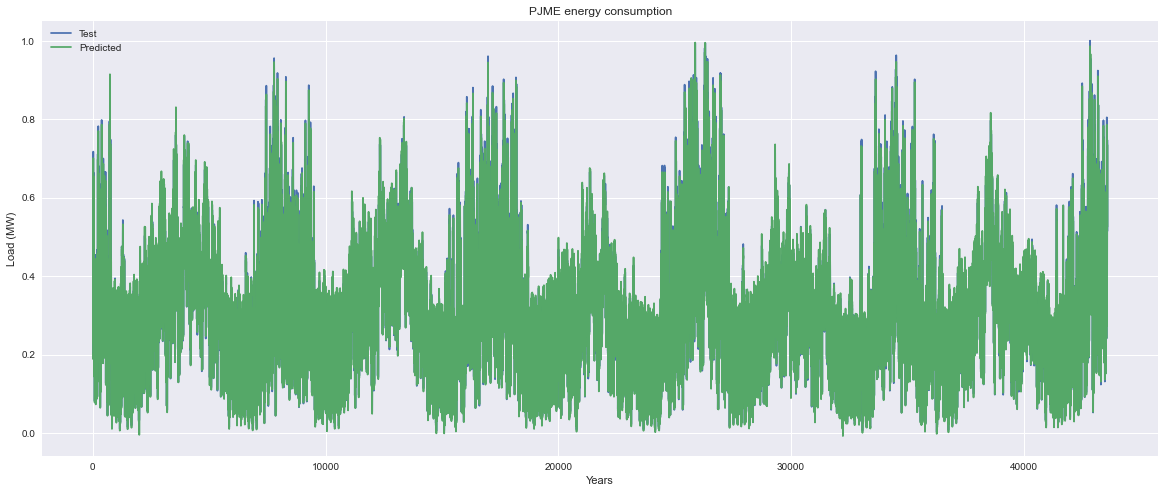

In [ ]:
# plotting the predicted values
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='Test')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Years')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.legend()
plt.show()

# we see that the predictions are almost the same as real values

6/6 [==============================] - 0s 2ms/step


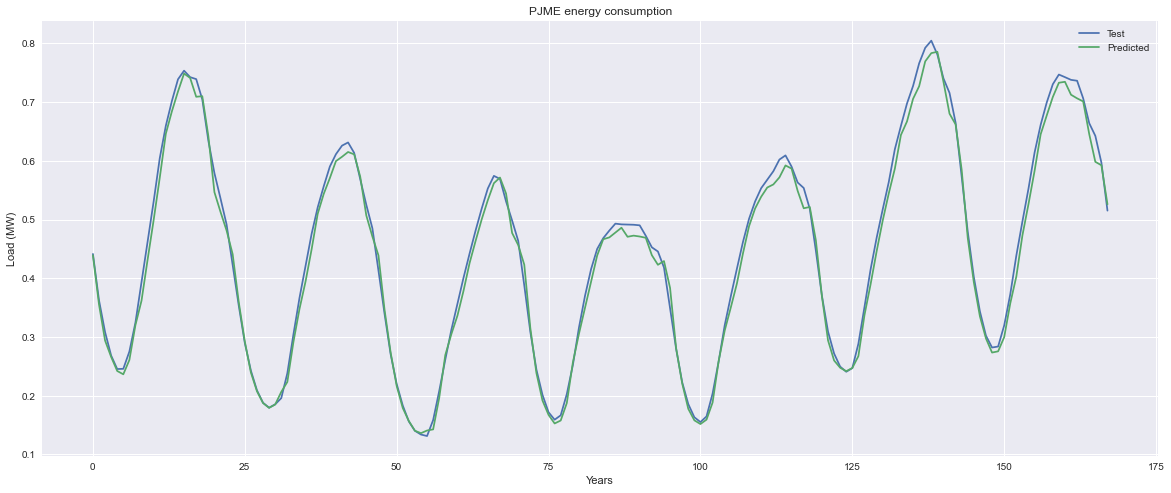

In [ ]:
# checking predictions for a week
y_pred = best_model.predict(x_test[-24*7:])

# plotting the predicted values
plt.figure(figsize=(20, 8))
plt.plot(y_test[-24*7:], label='Test')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Hours')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.legend()
plt.show()

23/23 [==============================] - 0s 2ms/step


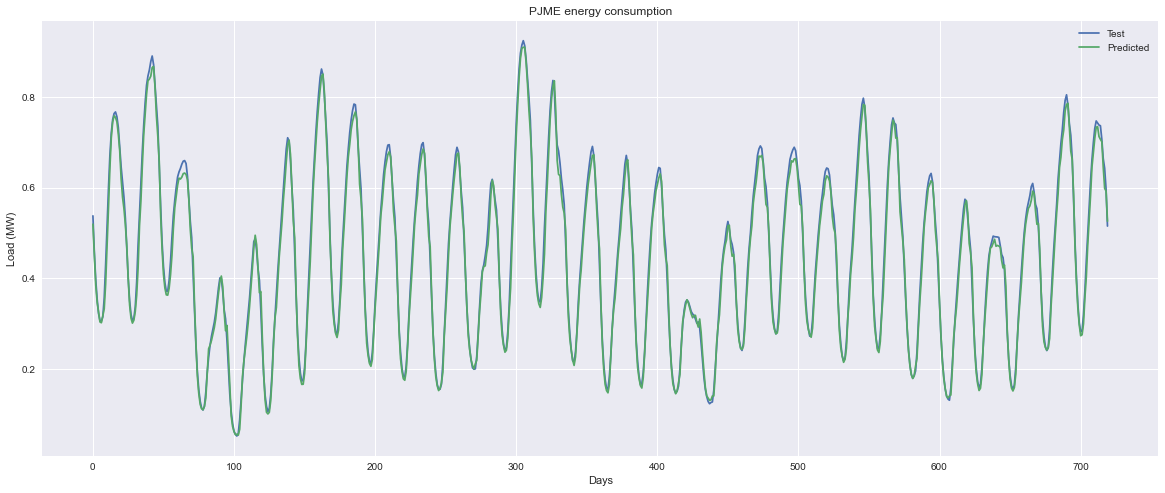

In [ ]:
# checking predictions for a month
y_pred = best_model.predict(x_test[-24*30:])

# plotting the predicted values
plt.figure(figsize=(20, 8))
plt.plot(y_test[-24*30:], label='Test')
plt.plot(y_pred, label='Predicted')
plt.xlabel('hours')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.legend()

274/274 [==============================] - 0s 2ms/step


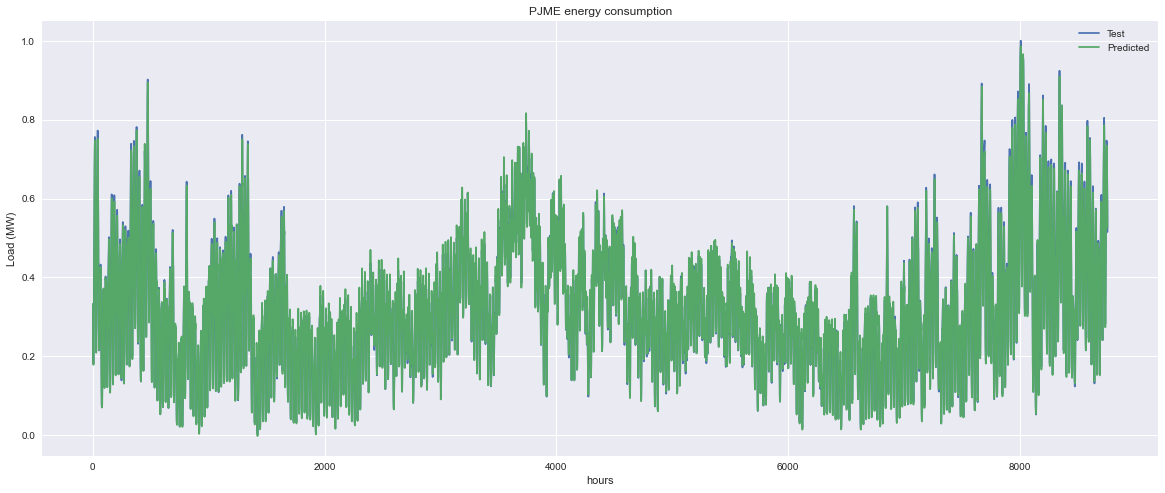

In [163]:
# checking predictions for a year
y_pred = best_model.predict(x_test[-24*365:])
# plotting the predicted values
plt.figure(figsize=(20, 8))
plt.plot(y_test[-24*365:], label='Test')
plt.plot(y_pred, label='Predicted')
plt.xlabel('hours')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.legend()